In [1]:
import os
from functools import reduce
import numpy as np
import pandas as pd
from scipy.stats import kstest,ttest_ind
import seaborn as sns
from matplotlib.ticker import MultipleLocator
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams.update({'font.size': 14, 'axes.linewidth': 2, 'xtick.major.width': 1.5, 'xtick.major.size': 7, 'ytick.major.width': 1.5, 'ytick.major.size': 7})
from matplotlib.backends.backend_pdf import PdfPages

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import explained_variance_score

In [2]:
def save_pdf(save_file, fig):
    pdf = PdfPages(save_file)
    pdf.savefig(fig, bbox_inches='tight', dpi=300)
    pdf.close()
    return

In [3]:
phenotype_file = "/data6/deepro/ukb_bmi/0_data_preparation_and_download/phenotype/data/bmi_processed/filtered_bmi_info.csv.gz"

In [4]:
phenotype_df = pd.read_csv(
    phenotype_file, 
    usecols=["sample_names", "genetic_sex", "age", "ethnic_background"] + [f"genetic_pca{i}" for i in range(1, 40)] + ["bmi_prs", "bmi"],
    index_col=["sample_names"]).dropna()

In [5]:
phenotype_df = phenotype_df.loc[phenotype_df.ethnic_background=="British"]
phenotype_df.index = phenotype_df.index.astype(str)

In [6]:
categorical_cols = ["genetic_sex"]
numerical_cols = ["age"] + [f"genetic_pca{i}" for i in range(1, 40)]
scaled_numerical_cols = ["bmi_prs"]

In [7]:
def train_model(df, categorical_cols, numerical_cols, scaled_numerical_cols):
    en = LabelEncoder()
    scaler = StandardScaler()
    # select the categorical and numerical columns
    # transform the categorical columns to integer values
    for cat_col in categorical_cols:
        df[cat_col] = en.fit_transform(df[cat_col])
    # scale the numerical columns
    df[numerical_cols] = scaler.fit_transform(df.loc[:, numerical_cols])
    # scale bmi separately
    df["bmi_scaled"] = scaler.fit_transform(df.loc[:, ["bmi"]])
    # Create the target variable (bmi_residuals) using linear regression
    X = df.loc[:, categorical_cols + numerical_cols + scaled_numerical_cols]
    y = df.loc[:, 'bmi_scaled']
    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)
    return y.values, y_pred

In [8]:
y, y_pred = train_model(phenotype_df, categorical_cols, numerical_cols, scaled_numerical_cols)

In [9]:
# https://www.nature.com/articles/s41576-021-00414-z
prs_exp_variance = explained_variance_score(y, y_pred)

In [10]:
prs_exp_variance

0.08499206246198532

In [11]:
genotype_file = "/data6/deepro/ukb_bmi/0_data_preparation_and_download/genotype/data/processed_burden/all_gene_burden.csv.gz"

In [12]:
def prepare_genotypes(genotype_df, gene_list):
    genotype_df = genotype_df.loc[genotype_df.gene.isin(gene_list)]
    genotype_df.loc[:, "samples"] = genotype_df.samples.str.split(",")
    genotype_df = genotype_df.explode("samples")
    genotype_df = pd.crosstab(genotype_df.samples, genotype_df.gene)
    return genotype_df

In [13]:
genotype_df = pd.read_csv(genotype_file)

In [14]:
def read_gene_files(gene_file):
    with open(gene_file, "r") as f:
        genes = [g.strip() for g in f.readlines()]
    return genes

In [15]:
other_study_files = [
    "/data6/deepro/ukb_bmi/0_data_preparation_and_download/bmi_genes/akbari_2021/data/akbari_genes.list",
    "/data6/deepro/ukb_bmi/0_data_preparation_and_download/bmi_genes/turcot_2018/data/turcot_genes.list"
]

In [16]:
other_study_genes = set(sum([read_gene_files(osf) for osf in other_study_files], []))

In [17]:
gdf = prepare_genotypes(genotype_df, other_study_genes)

In [18]:
geno_pheno_df = phenotype_df.merge(gdf, left_index=True, right_index=True, how="left").fillna(0.)

In [19]:
gdf.columns

Index(['ACHE', 'ALDH3A1', 'ANGPTL7', 'ANKRD27', 'ANO4', 'CALCR', 'DPP9',
       'ENTPD6', 'GIPR', 'GPR151', 'GPR75', 'HIP1R', 'KIAA0586', 'KSR2',
       'MAP1A', 'MC4R', 'PCSK1', 'PDE3B', 'PRKAG1', 'RAB21', 'RAPGEF3',
       'ROBO1', 'SLC6A17', 'SPARC', 'UBR2', 'UHMK1', 'ZBTB7B', 'ZFHX3', 'ZFR2',
       'ZNF169'],
      dtype='object', name='gene')

In [20]:
y, y_pred = train_model(geno_pheno_df, categorical_cols, numerical_cols, scaled_numerical_cols + list(gdf.columns))

In [21]:
prs_rare_exp_variance = explained_variance_score(y, y_pred)

In [22]:
prs_rare_exp_variance

0.0855626724771763

In [23]:
def get_combo_samples(combos, genotype_df):
    samples_per_gene = genotype_df.loc[genotype_df.gene.isin(combos)].samples.str.split(",").values
    samples_per_combo = reduce(lambda a,b: set(a).intersection(set(b)), samples_per_gene)
    return "|".join(sorted(samples_per_combo))


def prepare_genotypes(genotype_df, gene_list, combo_df):
    other_study_geno = genotype_df.loc[genotype_df.gene.isin(gene_list)]
    other_study_geno.loc[:, "samples"] = other_study_geno.samples.str.split(",")
    other_study_geno = other_study_geno.explode("samples")
    other_study_geno = pd.crosstab(other_study_geno.samples, other_study_geno.gene)

    combo_df["uniq_items"] = combo_df.uniq_items.apply(lambda x: x.replace("Input_", ""))
    combo_df["combos"] = combo_df.uniq_items.str.split("|")
    combo_df["combo_samples"] = combo_df.combos.apply(get_combo_samples, args=(genotype_df, ))
    combo_genes = set("|".join(combo_df.uniq_items.values).split("|"))
    combo_geno = genotype_df.loc[genotype_df.gene.isin(combo_genes)]
    all_combo_samples = "|".join(combo_df.combo_samples).split("|")
    combo_geno.loc[:, "samples"] = combo_geno.samples.str.split(",")
    combo_geno = combo_geno.explode("samples")
    combo_geno = combo_geno.loc[combo_geno.samples.isin(all_combo_samples)]
    combo_geno = pd.crosstab(combo_geno.samples, combo_geno.gene)

    genotype_df = combo_geno.merge(other_study_geno, how="outer", left_index=True, right_index=True).fillna(0.)
    return genotype_df

In [24]:
combo_files = [
    "/data6/deepro/ukb_bmi/2_rarecomb/data/british/combo2.csv",
    "/data6/deepro/ukb_bmi/2_rarecomb/data/british/combo3.csv"
    ]

combo_df = pd.concat([pd.read_csv(cf, usecols=["uniq_items"]) for cf in combo_files]) # pd.read_csv(combo_files[0], usecols=["uniq_items"]) # 

In [25]:
gdf = prepare_genotypes(genotype_df, other_study_genes, combo_df)

In [26]:
gdf.columns

Index(['AACS', 'AADACL3', 'AATF', 'ABCA1', 'ABCA12', 'ABCA13', 'ABCA3',
       'ABCA4', 'ABCA5', 'ABCA7',
       ...
       'RAPGEF3', 'ROBO1', 'SLC6A17', 'SPARC_y', 'UBR2_y', 'UHMK1', 'ZBTB7B',
       'ZFHX3', 'ZFR2', 'ZNF169'],
      dtype='object', name='gene', length=1564)

In [27]:
geno_pheno_df = phenotype_df.merge(gdf, left_index=True, right_index=True, how="left").fillna(0.)

In [28]:
y, y_pred = train_model(geno_pheno_df, categorical_cols, numerical_cols, scaled_numerical_cols + list(gdf.columns))

In [29]:
prs_rare_combo_exp_variance = explained_variance_score(y, y_pred)

In [30]:
prs_rare_combo_exp_variance

0.10557268521571173

In [35]:
prs_rare_exp_variance

0.0855626724771763

In [31]:
plot_df = pd.DataFrame({
    "Model Variates": ["PRS", "PRS + Rare", "PRS + Rare + Combos"], 
    "Variance explained": [prs_exp_variance*100, prs_rare_exp_variance*100, prs_rare_combo_exp_variance*100]})

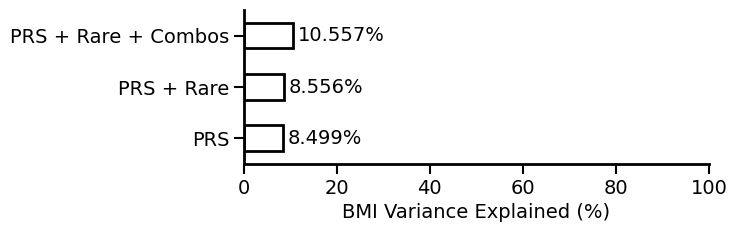

In [33]:
fig, axes = plt.subplots(1, 1, figsize=(6, 2))
axes.barh(
    plot_df["Model Variates"],
    plot_df["Variance explained"],
    height=0.5,
    edgecolor="k", linewidth=2,
    color="white"
    )
axes.set_xlim(0, 100)
axes.set_ylim(-0.5, 2.5)
axes.set_xlabel("BMI Variance Explained (%)")
axes.set_ylabel("")
axes.spines[['top', 'right']].set_visible(False)

rects =axes.patches
# Make some labels.
for rect in rects:
    width = rect.get_width()
    axes.text(
        width + 1, rect.get_y() + rect.get_height() / 2,  f"{round(width, 3)}%", ha="left", va="center"
    )

In [26]:
save_file = "/data6/deepro/ukb_bmi/0_data_preparation_and_download/phenotype/data/figures/explained_variance.pdf"

In [27]:
save_pdf(save_file, fig)